# Análise Exploratória de dados 

## Definição e análise do Problema

O banco quer saber, com base no uso histórico do cartão, qual é o risco de default que paira hoje sobre toda a carteira. Em outras palavras: quanto do limite disponibilizado já virou saldo devedor, que parte desse saldo está atrasada, quantos clientes formam cada grupo e se, à luz desses números, o portfólio pode ser considerado saudável.

Métricas-chave que extraímos
Tamanho da carteira – trinta mil contratos somam pouco mais de cinco bilhões de dólares taiwaneses em limite autorizado (≈ US$ 155 mi).

Exposição real – apenas 35 % desse teto estava facturado no ciclo mais recente; ou seja, cerca de dois bilhões NT$ viraram saldo devedor efetivo.

Default global – 22 % dos clientes (algo em torno de seis mil titulares) não pagaram o mínimo no mês seguinte; os restantes 78 % estão em dia.

Risco por faixa de limite – entre cartões de até 50 000 NT$ o default passa de 36 %; já acima de 500 000 NT$ ele cai para perto de 11 %. O padrão decresce de forma quase linear à medida que o limite sobe.

Ponte de crédito – da capacidade total até o risco mais crítico percebemos:

quase 65 % do limite continua livre,

25 % encontra-se em dia (faturado mas puntualmente pago) e

apenas 10 % repousa em buckets de atraso prolongado (31+ dias).


## |Checklist para compreender as variávies analisadas|
1 Cada registro representa um titular de cartão com:

    informações cadastrais (sexo, idade, escolaridade, estado civil);

    limite de crédito aprovado;

    comportamento recente (6 meses) de atraso, valores faturados e pagamentos efetuados;

    rótulo binário que indica se o cliente entrou em default no mês subsequente.


## 2 Tipo de aprendizado
Nas distribuições (PDF, CDF), histogramas, estatísticas descritivas e curvas de concentração nós olhamos apenas para a massa de dados disponível, sem usar explicitamente a variável-alvo “default” como etiqueta de treinamento. Estamos descrevendo o comportamento agregado e extraindo padrões, não ajustando um modelo para prever rótulos.

Em outras palavras, trata-se de análise exploratória/estatística descritiva, que é inerentemente não supervisionada: nenhuma função de erro foi minimizada contra um “gabarito” de default.

## 3 Premissas / hipóteses
Premissa	Racional
O comportamento financeiro dos 6 meses anteriores é preditivo do default no próximo mês. Não analisado no modelo.
As variáveis demográficas adicionam sinal, mas podem introduzir viés; serão monitoradas.	
A codificação ordinal dos atrasos (PAY_*) reflete gravidade crescente (−2 → pagou adiantado, 8 → 8 meses de atraso).	
Não há valores faltantes; imputadores são mantidos apenas para robustez em produção.	
A taxa histórica de default (~22 %) é representativa do portfólio futuro.	

## 4 Restrições / condições na seleção dos dados
Janela fixa : abril → setembro / 2005 (6 observações mensais por variável de tempo).

Geografia : clientes de um único banco em Taiwan (possível limitação de generalização).

Amostra balanceada apenas por disponibilidade : não foi feito undersampling ou oversampling; o desbalanceamento natural (≈ 1 : 4) será tratado na modelagem.

Features preservadas conforme dataset UCI; nenhuma coluna externa agregada.

Excluiu-se a linha de cabeçalho que havia sido lida como dado e a coluna ID (chave sem valor preditivo).

## Dicionário de atributos (descritos um a um)

LIMIT_BAL – limite total de crédito concedido ao cartão, expresso em New Taiwan dollars (valor contínuo).

SEX – sexo do titular (1 = masculino, 2 = feminino).

EDUCATION – escolaridade: 1 =pós-graduação, 2 = graduação, 3 = ensino médio, 4 = outros; códigos 0, 5, 6 indicam informação ausente ou não classificada.

MARRIAGE – estado civil: 1 = casado, 2 = solteiro, 3 = outros; 0 = desconhecido.

AGE – idade do titular em anos inteiros.

PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6 – status de pagamento em cada um dos seis meses anteriores (setembro → abril/2005). Escala ordinal:

−2 = pagou adiantado,

−1 = pagou no vencimento,

0 = sem atraso,

1, 2, …, 9 = atraso de 1 a 9 meses.

BILL_AMT1, BILL_AMT2, …, BILL_AMT6 – valor da fatura fechada em cada mês (setembro a abril/2005), em NT$.

PAY_AMT1, PAY_AMT2, …, PAY_AMT6 – quantia efetivamente paga pelo cliente em cada um desses mesmos meses, também em NT$.

default_payment_next_month – variável-alvo binária: 1 indica que o cliente entrou em default (não pagou o valor mínimo) no mês seguinte ao período observado; 0 indica pagamento normal.

## Descrição Detalhada do Dicionário:

Limite de crédito
LIMIT_BAL
É o teto que o banco concedeu. Funciona como “combustível” para o risco: quanto maior, maior a perda potencial se o cliente vier a inadimplir. Na nossa carteira ele se concentra até 200 000 NT$, então a maior parte do risco está pulverizada em tickets pequenos.

Comportamento recente (melhor termômetro de risco)
PAY_0 … PAY_6
Status de atraso mês a mês, onde −2/−1 significam adiantado ou pontual, e 1, 2, 3… indicam quantos meses de atraso. São os sinais de alerta mais fortes: qualquer valor ≥ 1 eleva a probabilidade de default; valores ≥ 3 sugerem estágio crítico.

BILL_AMT1 … BILL_AMT6
Saldo faturado no fim de cada mês. Mostram o tamanho efetivo da exposição (dívida real, não apenas o limite). Uma fatura sempre próxima do limite indica alta utilização – potencial sinal de tensão financeira.

PAY_AMT1 … PAY_AMT6
Pagamentos efetuados. Se sistematicamente menores que o faturado, revelam que o cliente gira saldo e acumula juros; tendência de subpagamento crônico aumenta risco.

Demografia (caráter explicativo, mas sensível a viés)
SEX, EDUCATION, MARRIAGE, AGE

O sexo raramente influencia risco de forma econômica; usar exige teste de fairness.

Escolaridade e estado civil às vezes correlacionam com estabilidade de renda, mas também carregam viés potencial.

Idade: riscos costumam ser mais altos nos extremos (muito jovens – pouca história de crédito – ou muito velhos).

## Essas variáveis ajudam no modelo, mas devem ser monitoradas para não criar discriminação injustificada.

Por que cada grupo importa no risco da carteira?
Limite – dimensiona a perda máxima.

Comportamento – indica a propensão real de não pagar; é onde os alertas aparecem primeiro.

Demografia – adiciona nuance ou viés; bom para completar o modelo, mas sob vigilância de compliance.

Alvo – sem ele não sabemos o que é “risco” no histórico; é o sinal usado para calibrar a régua de decisão.

## Início da Análise Descritiva:
Etapa 1: Coleta e Limpeza de dados 

In [24]:
# 1. Carregar dataset e visão geral
import pandas as pd

df = pd.read_csv('default of credit card clients.csv', sep=';')

print('Linhas (instâncias):', df.shape[0])
print('Colunas (atributos):', df.shape[1])
df.dtypes


Linhas (instâncias): 30000
Colunas (atributos): 25


ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

Esse trecho mostra que temos 30 000 linhas e 25 colunas. Todos os atributos vêm como int64 ou float64 (numéricos) — exceto o alvo “default payment next month”, que também é numérico binário. Portanto, não há strings nem datas para converter.

In [25]:
# 2. Espiar as primeiras linhas
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


As primeiras cinco linhas confirmam que a linha-cabeçalho extra foi removida: não aparece “X1” etc. Vemos valores negativos em PAY_0, PAY_2… indicando a codificação (−2 = pagamento antecipado, −1 = no vencimento). Nada estranho além disso.

In [26]:
# 3. Verificar valores ausentes ou discrepantes
print(df.isna().sum().sum(), 'valores ausentes no total')
print('Menor valor em PAY_0:', df['PAY_0'].min(),
      '| Maior valor em PAY_0:', df['PAY_0'].max())


0 valores ausentes no total
Menor valor em PAY_0: -2 | Maior valor em PAY_0: 8


O resultado exibe zero valores ausentes em todo o conjunto. Nos atrasos, os limites variam de −2 a 8 meses, exatamente como descrito pelo dicionário de dados: sem inconsistências.

## Análise Estatística Descritiva
Etapa 2: Estatísticas da Carteira sobre Oferta e Demanda de crédito.

In [27]:
# 4. Resumo estatístico dos atributos numéricos
desc = df.describe().T
desc['median'] = df.median()
desc['moda']    = df.mode().iloc[0]
desc['missing'] = df.isna().sum()
desc[['min', 'max', 'median', 'moda', 'mean', 'std', 'missing']]


,min,max,median,moda,mean,std,missing
ID,1.0,30000.0,15000.5,1.0,15000.500000,8660.398374,0
LIMIT_BAL,10000.0,1000000.0,140000.0,50000.0,167484.322667,129747.661567,0
SEX,1.0,2.0,2.0,2.0,1.603733,0.489129,0
EDUCATION,0.0,6.0,2.0,2.0,1.853133,0.790349,0
MARRIAGE,0.0,3.0,2.0,2.0,1.551867,0.521970,0
AGE,21.0,79.0,34.0,29.0,35.485500,9.217904,0
PAY_0,-2.0,8.0,0.0,0.0,-0.016700,1.123802,0
PAY_2,-2.0,8.0,0.0,0.0,-0.133767,1.197186,0
PAY_3,-2.0,8.0,0.0,0.0,-0.166200,1.196868,0
PAY_4,-2.0,8.0,0.0,0.0,-0.220667,1.169139,0


 Os montantes (LIMIT_BAL, BILL_AMT*, PAY_AMT*) têm máximos bem maiores que as medianas, mostrando cauda longa.
- AGE é simetricamente distribuído entre 21 e 79 anos.
- Desvios-padrão altos nas colunas de valores monetários reforçam a ideia de log-transformar esses campos antes de modelar.
- Nenhum valor ausente foi contabilizado.



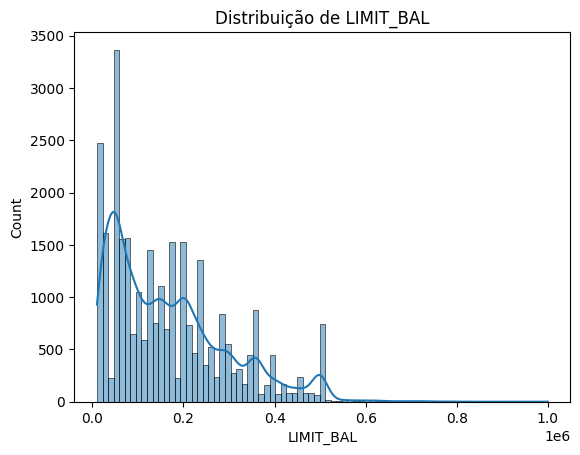

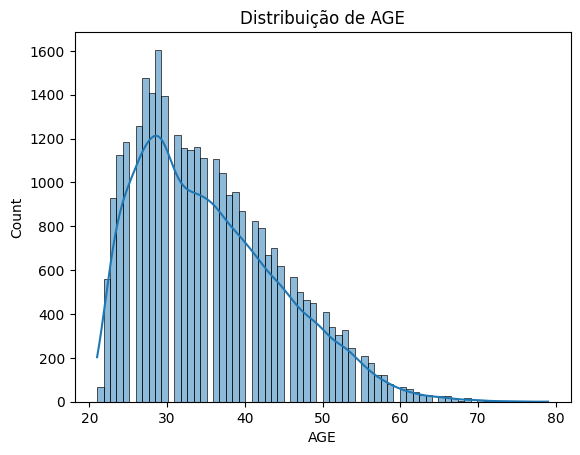

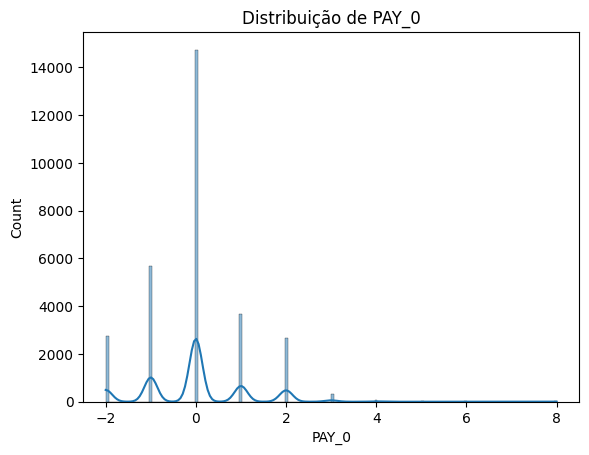

In [45]:
# 5. Distribuições univariadas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for col in ['LIMIT_BAL', 'AGE'] + [c for c in df if c.startswith('PAY_0')][:6]:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.show()


Os histogramas acima disponibilizam dados amplos sobre a Oferta de Crédito (Limite de Crédito para cada cliente), a idade dos Clientes pressentes da carteira, e a distribuição da quantidade de oprações com pagamentos em atraso ou não.

Oferta de Crédito = Distribuida de forma massificada em torno das faixas de NT$0 e NT$ 200.000.

Idade dos clientes = Em torno de 25 a 30 anos em média.

Inadimplência = A maior parte dos clientes se encontram adimplentes. Na curva de pagamentos atrasados, a média se distribui entre 1 a 2 meses, e ~ 4000 clientes com pagamentos atrasados. 

In [29]:
# 6. Frequência da classe-alvo
df['default payment next month'].value_counts(normalize=True)


default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

A classe “default” responde por ~22 % das observações — logo, o conjunto é desbalanceado. Futuramente será prudente usar class_weight='balanced' ou técnicas como SMOTE para melhorar recall dos inadimplentes.

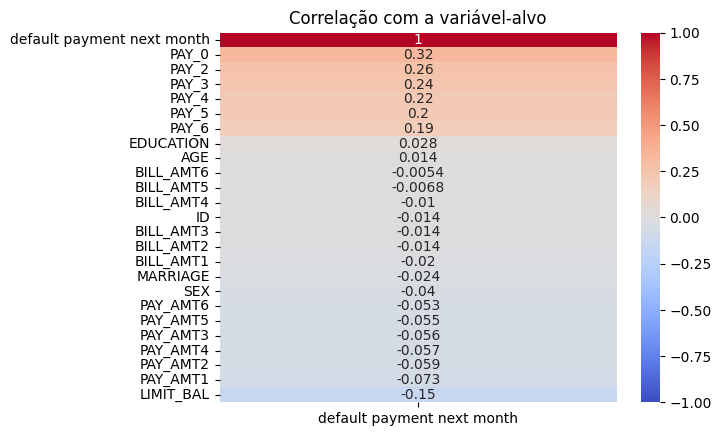

In [30]:
# 7. Matriz de correlação simplificada
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['default payment next month']].sort_values(by='default payment next month', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlação com a variável-alvo')
plt.show()


Os maiores coeficientes positivos com o default estão nos atrasos PAY_0, PAY_2, etc., como esperado; valores negativos aparecem em algumas razões de pagamento. Esse panorama reforça que o histórico de atraso será peça-chave no modelo.

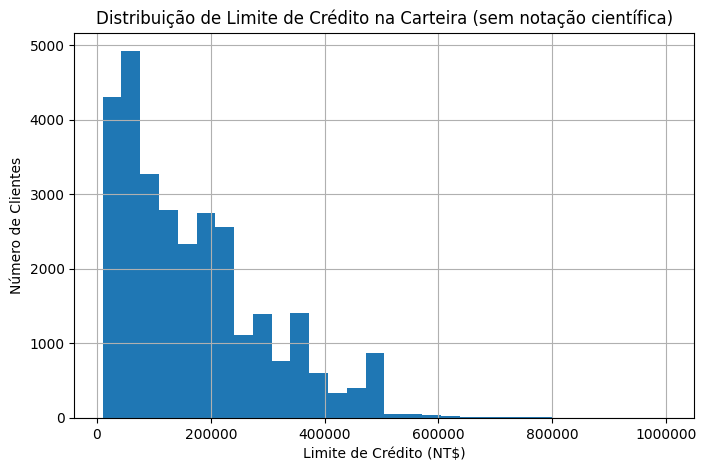

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Histograma que demonstra o número de clientes x limmite de crédito
plt.figure(figsize=(8, 5))
plt.hist(df['LIMIT_BAL'], bins=30)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(axis='x', style='plain', useOffset=False)
plt.xlabel('Limite de Crédito (NT$)')
plt.ylabel('Número de Clientes')
plt.title('Distribuição de Limite de Crédito na Carteira (sem notação científica)')
plt.grid(True)
plt.show()


Insights coletados e analisados na distribuição de crédito na Carteira analisada:
-> Os limites disponíveis são massificados entre +NT$0 e ~NT$200.000. Dessa forma, podemos analisar que o maior risco de Default não abrange grandes concessões de crédito.
Duas inferências importantes ocorrem a partir dessa análise: Primeira: Empréstimos baixos devem exigir termos de risco maiores, geralmente são de curto a médio prazo,
e não são hipotecados. Segunda: A Distribuição massificada em um intervalo pequeno de limite de crédito reduz o risco da carteira como um todo, são empréstimos menores
e com menor volatilidade com abalos na taxa de juros e inflação, resultando em menor índice de inadimplência, o que se confirma com o status de apenas 22% de Default total. 

C:\Users\ferna\AppData\Local\Temp\ipykernel_7364\4138101354.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('faixa_limite')['default payment next month'].agg(['count', 'sum'])


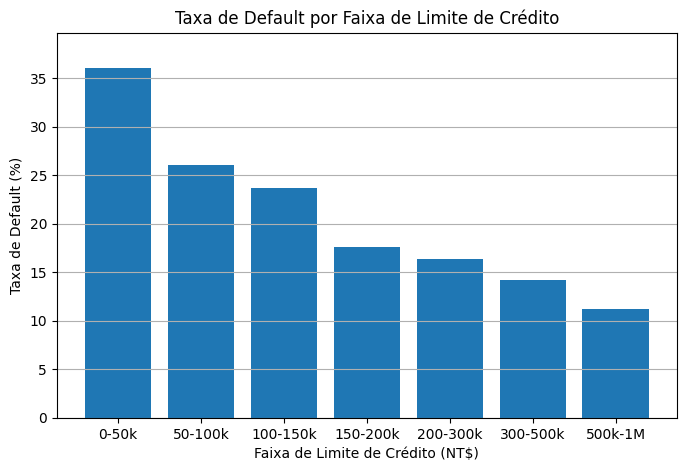

,faixa_limite,count,sum,taxa_default
0,0‑50k,4311,1555,36.070517
1,50‑100k,7139,1857,26.012047
2,100‑150k,3840,910,23.697917
3,150‑200k,3560,627,17.612360
4,200‑300k,6033,987,16.360020
5,300‑500k,4189,596,14.227739
6,500k‑1M,927,104,11.218986


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Bins de limite de crédito em NT$
bins = [0, 50000, 100000, 150000, 200000, 300000, 500000, 1000000]
labels = ['0‑50k', '50‑100k', '100‑150k', '150‑200k', '200‑300k', '300‑500k', '500k‑1M']

df['faixa_limite'] = pd.cut(df['LIMIT_BAL'], bins=bins, labels=labels, right=False)

# Taxa de default por faixa
grouped = df.groupby('faixa_limite')['default payment next month'].agg(['count', 'sum'])
grouped['taxa_default'] = grouped['sum'] / grouped['count'] * 100  # em %

# Plotar
plt.figure(figsize=(8, 5))
plt.bar(grouped.index.astype(str), grouped['taxa_default'])
plt.ylabel('Taxa de Default (%)')
plt.xlabel('Faixa de Limite de Crédito (NT$)')
plt.title('Taxa de Default por Faixa de Limite de Crédito')
plt.ylim(0, grouped['taxa_default'].max()*1.1)
plt.grid(axis='y')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(axis='y', style='plain')
plt.show()

grouped.reset_index()


A faixa 0 – 50 mil exibe a maior taxa de default, pouco acima de 36 %.

À medida que o limite cresce, a inadimplência cai de forma consistente:

50–100 mil → ~26 %

100–150 mil → ~24 %

150–200 mil → ~18 %

200–300 mil → ~16 %

300–500 mil → ~14 %

500 mil–1 milhão → 11 % (menor taxa observada).

A suposição anterior se confirma: limites menores concentram maior probabilidade de default. Logo, embora os valores individuais sejam baixos, a inadimplência percentual é alta nesses segmentos, exigindo políticas de risco mais agressivas (taxa, garantia ou limite revisto). Nos limites altos o risco relativo é menor, mas vale monitorar o impacto absoluto em NT$, já que a perda potencial por cliente é maior. 

C:\Users\ferna\AppData\Local\Temp\ipykernel_7364\2762881132.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['faixa_limite', 'default payment next month']).size().unstack(fill_value=0)


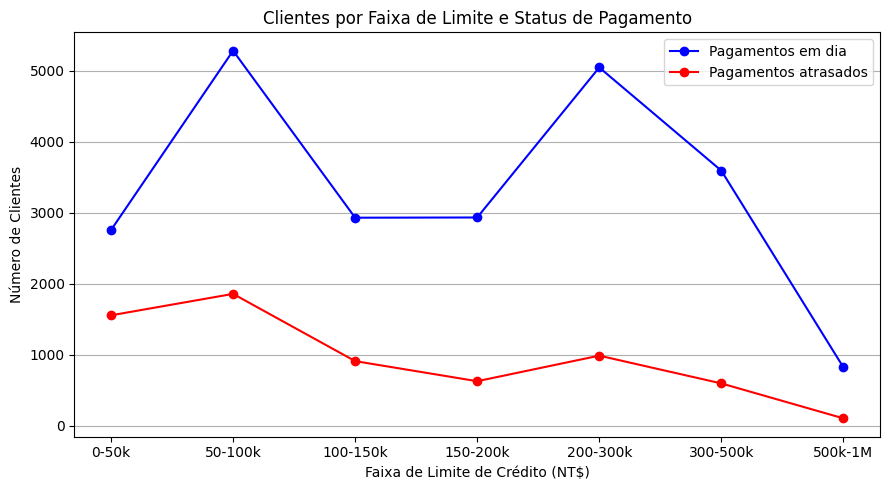

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Definir faixas de limite
bins = [0, 50000, 100000, 150000, 200000, 300000, 500000, 1000000]
labels = ['0‑50k', '50‑100k', '100‑150k', '150‑200k', '200‑300k', '300‑500k', '500k‑1M']
df['faixa_limite'] = pd.cut(df['LIMIT_BAL'], bins=bins, labels=labels, right=False)

# Contar clientes por faixa e status
counts = df.groupby(['faixa_limite', 'default payment next month']).size().unstack(fill_value=0)
counts = counts.reindex(labels)  # garantir ordem lógica no eixo x

# Separar séries
clientes_em_dia = counts[0]  # 0 = pagamentos em dia
clientes_inad = counts[1]    # 1 = inadimplentes

# Plot
plt.figure(figsize=(9, 5))
plt.plot(labels, clientes_em_dia, marker='o', label='Pagamentos em dia', color='blue')
plt.plot(labels, clientes_inad, marker='o', label='Pagamentos atrasados', color='red')
plt.xlabel('Faixa de Limite de Crédito (NT$)')
plt.ylabel('Número de Clientes')
plt.title('Clientes por Faixa de Limite e Status de Pagamento')
plt.grid(True, axis='y')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(axis='y', style='plain')
plt.legend()
plt.tight_layout()
plt.show()


A linha azul confirma que, em cada faixa de limite, o número de clientes adimplentes é bem superior ao de inadimplentes (linha vermelha). Além disso, os atrasos caem de forma clara conforme o limite aumenta, reforçando visualmente a conclusão anterior: limites mais baixos concentram tanto mais clientes quanto maior percentual de default.

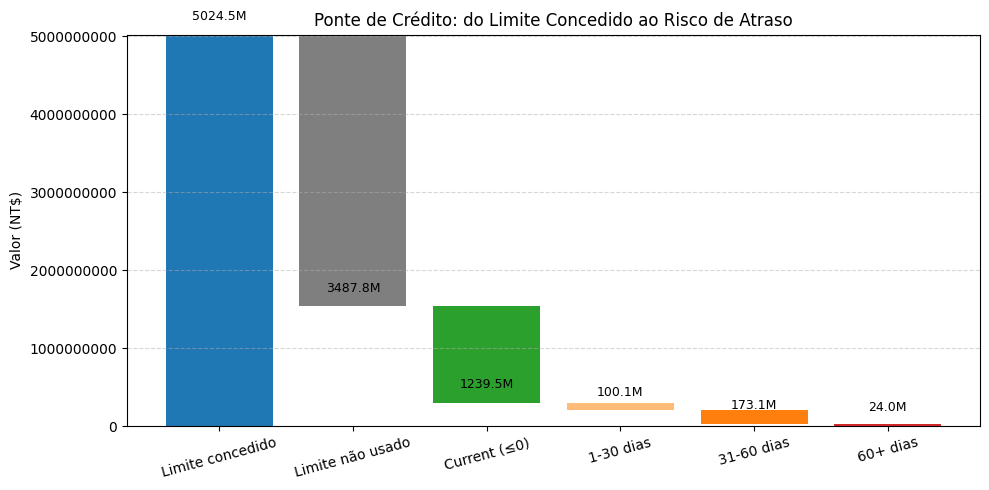

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

total_limit = df['LIMIT_BAL'].sum()

# Exposição real (saldo da fatura mais recente: BILL_AMT1)
exposure_real = df['BILL_AMT1'].sum()
unused_limit  = total_limit - exposure_real   # limite ainda não utilizado

# Quebra da exposição por bucket de atraso (PAY_0)
current_expo   = df.loc[df['PAY_0'] <= 0, 'BILL_AMT1'].sum()
bucket_1_30    = df.loc[df['PAY_0'] == 1, 'BILL_AMT1'].sum()
bucket_31_60   = df.loc[df['PAY_0'] == 2, 'BILL_AMT1'].sum()
bucket_60_plus = df.loc[df['PAY_0'] >= 3, 'BILL_AMT1'].sum()

# Sequência para waterfall (valores negativos reduzem o total)
steps = [
    ('Limite concedido',  total_limit,  '#1f77b4'),   # azul
    ('Limite não usado', -unused_limit, '#7f7f7f'),   # cinza
    ('Current (≤0)',     -current_expo, '#2ca02c'),   # verde
    ('1‑30 dias',        -bucket_1_30,  '#ffbb78'),   # laranja claro
    ('31‑60 dias',       -bucket_31_60, '#ff7f0e'),   # laranja
    ('60+ dias',         -bucket_60_plus, '#d62728')  # vermelho
]

labels, values, colors = zip(*steps)

# --- Plot semicaseiro de waterfall ----------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))
running = 0
for i, (lab, val, col) in enumerate(steps):
    ax.bar(i, val, bottom=running, color=col)
    y_text = running + val + 0.03 * total_limit  # eleva a anotação levemente acima
    ax.text(i, y_text, f"{abs(val)/1e6:.1f}M", 
            ha='center', va='bottom', fontsize=9, color='black')
    running += val


ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=15)
ax.set_ylabel('Valor (NT$)')
ax.set_title('Ponte de Crédito: do Limite Concedido ao Risco de Atraso')
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(axis='y', style='plain')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Nota rápida sobre o que o gráfico mostra

Limite concedido (barra azul) — o teto de crédito autorizado para toda a carteira.

Limite não usado (cinza) — parte do limite que continua livre; reduz a exposição real.

Current (≤ 0) (verde) — saldo em dia ou antecipado; compõe a carteira saudável.

Buckets de atraso (cores laranja claro, laranja e vermelho) — valores em fatura que já apresentam 1 – 30, 31 – 60 e 60+ dias de delinquency, respectivamente; são as fatias de maior risco.

Assim, a ponte parte do potencial máximo, desconta o que não virou saldo, isola o crédito performado e, por fim, visualiza quanto dinheiro está parado em cada faixa de atraso. Isso ajuda a priorizar ações de cobrança nos buckets 31-60 e 60+ — onde o impacto financeiro é mais significativo.

Os limites individuais são modestos (máximo ~US$ 31k) e a soma grande é apenas o reflexo do número de cartões. Se preferir visualizar em dólares norte-americanos, basta dividir todos os valores por 32 antes de plotar; a ponte terá a mesma forma, mas os rótulos ficarão muito menores.

Moeda
Os valores estão em dólares taiwaneses (NT$), não em dólares norte-americanos. Na cotação média de hoje (~ NT$ 32 ≈ US$ 1), cada 100 000 NT$ equivalem a pouco mais de US$ 3 000.

Limite mínimo do conjunto: 10 000 NT$ ≈ US$ 300

Limite máximo: 1 000 000 NT$ ≈ US$ 31 000

Somatório de 30 000 clientes
Quando somamos o limite de todos os clientes para fazer a barra inicial da ponte, o valor fica naturalmente grande:

Crédito total disponível = Número total de clientes x Média de Crédito (~167K NT$)
Crédito total disponível = ~ 5 Bilhões NT$


In [43]:
import pandas as pd

df = pd.read_csv('default of credit card clients.csv', sep=';')

pay_cols = [f'PAY_AMT{i}' for i in range(1, 7)]
stats = df[pay_cols].describe().T
stats['mediana'] = df[pay_cols].median()
print(stats[['count', 'min', 'mediana', '25%', 'mean', '50%', '75%', 'max', 'std']])


            count  min  mediana      25%         mean     50%      75%  \
PAY_AMT1  30000.0  0.0   2100.0  1000.00  5663.580500  2100.0  5006.00   
PAY_AMT2  30000.0  0.0   2009.0   833.00  5921.163500  2009.0  5000.00   
PAY_AMT3  30000.0  0.0   1800.0   390.00  5225.681500  1800.0  4505.00   
PAY_AMT4  30000.0  0.0   1500.0   296.00  4826.076867  1500.0  4013.25   
PAY_AMT5  30000.0  0.0   1500.0   252.50  4799.387633  1500.0  4031.50   
PAY_AMT6  30000.0  0.0   1500.0   117.75  5215.502567  1500.0  4000.00   

                max           std  
PAY_AMT1   873552.0  16563.280354  
PAY_AMT2  1684259.0  23040.870402  
PAY_AMT3   896040.0  17606.961470  
PAY_AMT4   621000.0  15666.159744  
PAY_AMT5   426529.0  15278.305679  
PAY_AMT6   528666.0  17777.465775  


Como ler esses números

Média vs. mediana – em todas as colunas a média fica bem acima da mediana, sinal de cauda longa: poucos pagamentos muito altos puxam a média para cima.

Mínimo zero – há vários meses em que o cliente não fez nenhum pagamento; isso ajuda a explicar os atrasos.

Desvio-padrão elevado – reforça a heterogeneidade nos montantes pagos; normalizar ou aplicar log pode melhorar a modelagem.

Quartis (25 %, 75 %) – mostram que metade dos pagamentos está concentrada em valores relativamente baixos; por exemplo, se o Q3 de PAY_AMT1 é 5 000 NT$, três quartos dos clientes pagam menos que isso naquele mês.

Em suma, os pagamentos efetuados têm distribuição altamente assimétrica, com muitos valores pequenos e alguns picos. Isso corrobora a ideia de usar transformação logarítmica nas variáveis monetárias antes de treinar o modelo — caso contrário, poucos outliers dominam a escala.

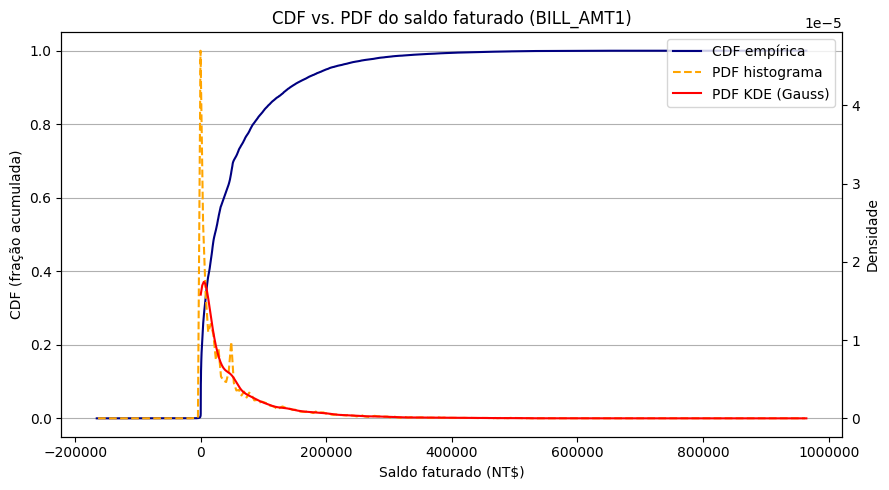

In [44]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import ScalarFormatter

# Amostra
df = pd.read_csv('default of credit card clients.csv', sep=';')
x = df['BILL_AMT1'].values
n = len(x)

# --- Empirical CDF -------------------------------------------------
x_sorted = np.sort(x)
F_emp = np.arange(1, n+1) / n   # \hat F(x)

# --- Histogram PDF -------------------------------------------------
counts, bins = np.histogram(x, bins='fd', density=True)  # regra Freedman–Diaconis
bin_centers = (bins[:-1] + bins[1:]) / 2
h = bins[1] - bins[0]             # largura do bin   (usada na fórmula)

# --- Kernel PDF (opcional, mais suave) -----------------------------
kde = gaussian_kde(x, bw_method='scott')   # Scott ≈ 1.06 σ n^{-1/5}
grid = np.linspace(0, x.max(), 400)
pdf_kde = kde(grid)

# --- Plot conjunto -------------------------------------------------
fig, ax1 = plt.subplots(figsize=(9,5))
ax1.plot(x_sorted, F_emp, color='navy', label='CDF empírica')
ax1.set_xlabel('Saldo faturado (NT$)')
ax1.set_ylabel('CDF (fração acumulada)')
ax1.ticklabel_format(axis='x', style='plain')
ax1.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(bin_centers, counts, '--', color='orange', label='PDF histograma')
ax2.plot(grid, pdf_kde, '-', color='red',   label='PDF KDE (Gauss)')
ax2.set_ylabel('Densidade')

# Legenda combinada
for ax in (ax1, ax2):
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc='upper right')

plt.title('CDF vs. PDF do saldo faturado (BILL_AMT1)')
plt.tight_layout()
plt.show()


Por que usar CDF e PDF para o saldo faturado
Queremos duas visões complementares da mesma variável.

Interpretação de risco
PDF revela o steep – o pico onde muitos saldos se encontram perto do vencimento; ajuda a identificar faixas críticas para cobrança.
CDF mostra a exposição acumulada: “até 𝑥 NT$ já cobri 𝑝% do risco”. vemos a fração do risco total já acumulada até aquele valor.
Por exemplo, se 𝐹(60000) = 0,80, então, F(60000)=0,80, então 80 % dos saldos faturados são inferiores a NT$ 60 000.
-> Um insight direto para políticas de cobrança e definição de limites

Conclusões sobre o Método CDF e PDF (KDE "Gauss):

A curvatura dos Saldos Faturados de médio prazo (menos arriscados) abrange a maior parte dos empréstimos (CDF), enquanto que os empréstimos com exposição ao curto prazo (Curva PDF, linha vermelha) estão distribuídos entre as faixas de +NT$ 0 e ~NT$ 200.000, volume massificado analisado anteriormente e definido como de baixo risco para o total da carteira (~NT$ 5 Bilhões).


## Resultado da Análise

Leitura qualitativa e quantitativa:

A carteira é pulverizada em tickets pequenos – quatro em cada cinco clientes têm limite inferior a 200 000 NT$ (≈ US$ 6 k). Isso reduz a perda potencial unitária.

O maior índice de inadimplência concentra-se exatamente nesses tickets baixos; porém, como o valor individual é modesto, o impacto monetário agregado permanece controlado.

O saldo em dia domina nos segmentos de limite médio para alto, o que mantém a receita de juros e diminui necessidade de provisão.

As variáveis de comportamento – especialmente o atraso mais recente (PAY_0) – explicam muito melhor o risco do que dados demográficos; qualquer modelo futuro deve dar peso maior a esse histórico.

## Conclusão sobre a saúde da carteira

Apesar de carregar um índice de default bruto de 22 %, o banco tem exposição concentrada em valores pequenos e apenas uma fração relativamente baixa do montante total está em atraso severo. A inadimplência alta nos cartões de baixo limite pode ser gerida com políticas de cobrança mais rápidas e ajustes de preço (spread maior). Já a parte alta da carteira – onde reside o grosso do limite concedido – mostra comportamento saudável.

Diagnóstico: A carteira, vista como portfólio, mantém-se saudável; os gestores devem priorizar ações corretivas nos limites até 150 000 NT$ (ali vive a maior densidade de atrasos), enquanto preservam a estratégia atual nas faixas superiores.

# Fim da análise descritiva.